### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%time
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:06, 1590.56it/s]

Wall time: 2min 6s



Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [5]:
len(responses)

153499

In [6]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
df.text = df.text.str.lower()

### Часть 1. Анализ текстов
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    - слов
    - слов без стоп-слов
    - лемм
    - существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    - какое слово встречается чаще, "сотрудник" или "клиент"?
    - сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

#### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [9]:
df.groupby('city').text.count().reset_index().sort_values('text', ascending=False)

,city,text
2175,г. Москва,55354
3568,г. Санкт-Петербург,14342
1034,г. Екатеринбург,2337
2785,г. Новосибирск,2300
2672,г. Нижний Новгород,1976
...,...,...
2334,"г. Москва, Ногинск (Москва)",1
2333,"г. Москва, Новосибирск",1
2332,"г. Москва, Николоямская ул., 31",1
2330,"г. Москва, Московская область",1


In [10]:
df.groupby('bank_name').text.count().reset_index().sort_values('text', ascending=False)

,bank_name,text
502,Сбербанк России,26327
34,Альфа-Банк,10224
106,ВТБ 24,8185
482,Русский Стандарт,7943
625,Хоум Кредит Банк,7549
...,...,...
508,Северный Народный Банк,1
509,Сельмашбанк,1
512,Сиббизнесбанк,1
513,Сибконтакт,1


#### 2. Постройте гистограмы длин слов в символах и в словах

In [11]:
df['symbol_length'] = df.text.apply(len)

In [12]:
df['word_length'] = df.text.str.split().apply(len)

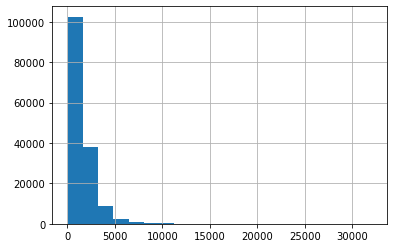

In [13]:
df['symbol_length'].hist(bins=20)

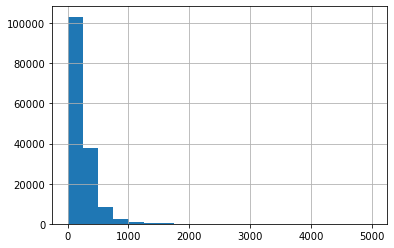

In [14]:
df['word_length'].hist(bins=20)

#### 3. Найдите 10 самых частых:
    - слов
    - слов без стоп-слов
    - лемм
    - существительных

In [15]:
ru_words = re.compile("[А-Яа-я]+")

def words_only(text):
    return ru_words.findall(text)

In [23]:
len(df)

153499

In [18]:
from collections import Counter

In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords_ru = stopwords.words('russian')
print(stopwords_ru)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [21]:
%%time
corpus = [token for tweet in df.text for token in words_only(tweet)]
print(len(corpus))

35429373
Wall time: 17 s


### 10 самых частых слов

In [22]:
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

In [24]:
%%time
corpus_no_stop_words = [token for token in corpus if token not in stopwords_ru]
print(len(corpus_no_stop_words))

22351585
Wall time: 1min 14s


### 10 самых частых слов без стоп-слов

In [25]:
freq_dict = Counter(corpus_no_stop_words)
freq_dict.most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('это', 183365),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('т', 91756),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169)]

In [26]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [27]:
def lemmatize(word):
    p = morph.parse(word)[0]
    return p.normal_form

print(lemmatize('доброго'))

добрый


In [28]:
%%time
corpus_lemm = [lemmatize(token) for token in corpus_no_stop_words]
print(len(corpus_lemm))
corpus_lemm[:10]

22351585
Wall time: 1h 53min 34s


['добрый',
 'день',
 'являться',
 'клиент',
 'банк',
 'поручитель',
 'кредитный',
 'договор',
 'также',
 'являться']

### 10 самых частых лемм

In [29]:
freq_dict = Counter(corpus_lemm)
freq_dict.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('это', 200057),
 ('деньга', 179819),
 ('день', 173116),
 ('мой', 163042),
 ('кредит', 156177),
 ('который', 149017),
 ('отделение', 144050),
 ('клиент', 136892)]

In [ ]:
# !pip install pymystem3
# from pymystem3 import Mystem
# mystem_analyzer = Mystem()
# print(mystem_analyzer.lemmatize(example))

In [30]:
def filter_noun(word):
    return 'NOUN' in morph.parse(word)[0].tag

In [31]:
filter_noun('миша')

True

In [32]:
%%time
corpus_noun = [token for token in corpus_lemm if filter_noun(token)]
print(len(corpus_noun))

10823799
Wall time: 1h 43min 4s


### 10 самых частых существительных

In [33]:
freq_dict = Counter(corpus_noun)
freq_dict.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('деньга', 179819),
 ('день', 173116),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счёт', 126894),
 ('сумма', 111232)]

In [35]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


# morph = pymorphy2.MorphAnalyzer()
# def lemmatize(text, lemmatizer=morph):
#     lemmas1 = [lemmatizer.parse(word)[0].normal_form for word in sent1.split()]
#     return ' '.join(lemmas1)
    

def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    try:
        return " ".join(res).strip()  
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text)))

In [36]:
%%time
df.text = df.text.apply(preprocess)

Wall time: 4h 3min 55s


#### 4. Постройте кривые Ципфа и Хипса

- Закон Ципфа

Эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

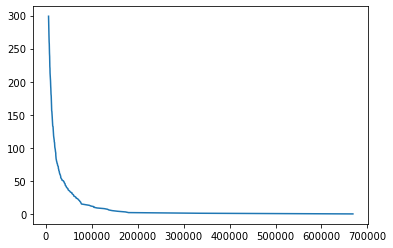

In [37]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Закон Хипса

С увеличением длины текста (количества токенов), количество слов увеличивается в соответствии с законом: $|V| = K*N^b$


$N$  –  число токенов, $|V|$  – количество слов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

In [39]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))
#     n_tokens.append(len(cnt.values()))

100%|█████████████████████████████████████████████████████████████████████████████████████| 153499/153499 [17:40<00:00, 144.68it/s]


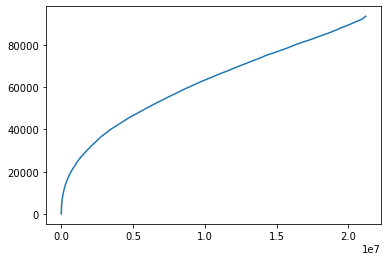

In [41]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

#### 5. Ответьте на следующие вопросы:
    - какое слово встречается чаще, "сотрудник" или "клиент"? - клиент
    - сколько раз встречается слова "мошенничество" и "доверие"? - мошенничество

In [42]:
print(freq_dict['сотрудник'])
print(freq_dict['клиент'])

134168
136892


In [43]:
print(freq_dict['мошенничество'])
print(freq_dict['доверие'])

3244
2108


#### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
df_grades = df[df['rating_grade'].notna()]

In [46]:
len(df_grades)

88658

In [47]:
def get_tfidf_top_features(documents, ngram_range=(1,1), n_top=10):
    vec = TfidfVectorizer(ngram_range=ngram_range, stop_words=stopwords_ru)
    bow = vec.fit_transform(documents)
    importance = np.argsort(np.asarray(bow.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(vec.get_feature_names())
    return tfidf_feature_names[importance[:n_top]]

- оценка 5

In [48]:
get_tfidf_top_features(documents=df[df['rating_grade'] == 5].text, ngram_range=(1,1), n_top=10)

array(['банк', 'карта', 'всё', 'вклад', 'кредит', 'очень', 'отделение',
       'день', 'клиент', 'сотрудник'], dtype='<U80')

In [49]:
get_tfidf_top_features(documents=df[df['rating_grade'] == 5].text, ngram_range=(2,2), n_top=10)

array(['интернет банк', 'кредитный карта', 'сотрудник банк',
       'клиент банк', 'отделение банк', 'являться клиент',
       'следующий день', 'всё вопрос', 'альфа банк', 'добрый день'],
      dtype='<U118')

- оценка 1

In [50]:
get_tfidf_top_features(documents=df[df['rating_grade'] == 1].text, n_top=10)

array(['банк', 'карта', 'деньга', 'кредит', 'отделение', 'день', 'счёт',
       'заявление', 'сотрудник', 'всё'], dtype='<U73')

In [51]:
get_tfidf_top_features(documents=df[df['rating_grade'] == 1].text, ngram_range=(2,2), n_top=10)

array(['сотрудник банк', 'кредитный карта', 'денежный средство',
       'отделение банк', 'написать заявление', 'горячий линия',
       'ваш банк', 'колл центр', 'рабочий день', 'альфа банк'],
      dtype='<U85')

### Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

In [52]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [58]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [59]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [63]:
from gensim.models import lsimodel

In [64]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

Wall time: 6min 4s


In [65]:
lsi.show_topics(5)

[(0,
  '0.197*"карта" + 0.135*"кредит" + 0.117*"деньга" + 0.111*"заявление" + 0.109*"счёт" + 0.102*"вклад" + 0.102*"банкомат" + 0.102*"отделение" + 0.098*"сбербанк" + 0.098*"сумма"'),
 (1,
  '-0.420*"вклад" + 0.355*"кредит" + -0.188*"банкомат" + 0.162*"страховка" + 0.154*"платёж" + -0.154*"карта" + 0.149*"задолженность" + 0.141*"погашение" + -0.112*"очередь" + 0.111*"погасить"'),
 (2,
  '-0.479*"вклад" + 0.272*"банкомат" + 0.227*"карта" + 0.205*"сбербанк" + -0.158*"кредит" + 0.130*"заявление" + -0.129*"договор" + 0.128*"операция" + 0.120*"средство" + 0.119*"деньга"'),
 (3,
  '-0.274*"вклад" + -0.214*"сумма" + 0.202*"заявка" + 0.187*"номер" + -0.182*"руб" + -0.157*"договор" + -0.157*"платёж" + -0.154*"погашение" + -0.144*"рубль" + -0.143*"средство"'),
 (4,
  '-0.449*"карта" + 0.296*"банкомат" + -0.197*"лимит" + -0.188*"кредитный" + 0.166*"номер" + 0.127*"терминал" + 0.124*"звонок" + 0.123*"деньга" + 0.120*"купюра" + -0.117*"комиссия"')]

- первая тема говорит о кредите и вкладе, деньгах и картах
- вторая тема похоже говорит больше о кредите, а не вкладе, страховках и задолженностях
- третья тема говорит снятие денег в банкомате сбербанка
- 4-ая тема видимо говорит о заявке, может быть о кредите или что-то подобное
- 5-ая тема говорит о банкомате, терминалах и купюрах

### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

In [66]:
df_grades = df[(df['rating_grade'] == 1) | (df['rating_grade'] == 5)]
df_grades.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,symbol_length,word_length
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,открыть вклад счёт плюс зарплатный карта рубль...,1.0,2214,339
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,добрый время вчера поступить смс уведомление б...,1.0,2159,313
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,г около час прийти указанный офис намерение по...,1.0,1262,185
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,оплата коммунальный платёж пользоваться пласти...,1.0,412,56
94,г. Чапаевск,False,Некомпетентность сотрудника Сбербанка при пров...,16,лицензия № 1481,usmanovaket,Сбербанк России,2015-06-03 16:00:12,апрель год прийти отделение сбербанк г чапаевс...,1.0,1663,265


In [67]:
df_grades['rating_grade'].value_counts()

1.0    47387
5.0    14713
Name: rating_grade, dtype: int64

In [74]:
df_grades = pd.concat([df[(df['rating_grade'] == 1)].sample(10000), df[(df['rating_grade'] == 5)].sample(10000)]).reset_index(drop=True)
df_grades.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,symbol_length,word_length
0,г. Санкт-Петербург,False,"""Не работает по техническим причинам""...",3,лицензия № 2810 (отозвана),iechechik,Русский Земельный Банк,2014-03-17 10:41:00,суббота должный закончиться вклад спб офис поэ...,1.0,576,89
1,г. Биробиджан,False,Не могу закрыть счет по кредитной карте,3,лицензия № 2766,zim.irin2011,ОТП Банк,2012-09-09 11:28:00,дважды писать заявление закрытие счёт ваш банк...,1.0,672,108
2,г. Москва,False,"Бесчеловечно, бессердечно и непрофессионально!",2,лицензия № 2748,Babylya008,Банк Москвы,2015-05-14 14:14:00,возможность поставить оценка добрый день весь ...,1.0,2888,428
3,г. Новосибирск,False,Внесите деньги сегодня - получите через полтор...,3,лицензия № 1481,Janke86,Сбербанк России,2014-05-27 12:14:00,май пытаться пополнить карта сбербанк банкомат...,1.0,727,113
4,г. Санкт-Петербург,False,Неисполнение обязательств банком Ренессанс Кап...,4,лицензия № 3354,Fetiskina,Ренессанс Кредит,2012-05-11 00:45:00,проблема взять кредит точнее выплачивать кажды...,1.0,2550,396


In [75]:
df_grades['rating_grade'].value_counts()

5.0    10000
1.0    10000
Name: rating_grade, dtype: int64

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [77]:
x_train, x_test, y_train, y_test = train_test_split(df_grades.text, df_grades.rating_grade, random_state=0)

In [78]:
print(df_grades.shape)
print(x_train.shape)
print(x_test.shape)

(20000, 12)
(15000,)
(5000,)


In [79]:
def text_classification(X, y, clf):
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy, f_measure = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred) # F-measure
    print(f'accuracy: {accuracy:.2}, F-measure: {f_measure:.2}')

In [81]:
# 1-ый вариант: tf-idf + LSI
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

text_classification(df_grades.text, df_grades.rating_grade, clf)

accuracy: 0.65, F-measure: 0.65


In [82]:
# учет только биграмм
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2, 2),)), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

text_classification(df_grades.text, df_grades.rating_grade, clf)

accuracy: 0.76, F-measure: 0.76


In [83]:
# учет только триграмм
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(3, 3),)), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

text_classification(df_grades.text, df_grades.rating_grade, clf)

accuracy: 0.52, F-measure: 0.54


In [84]:
# 2-ой вариант: LDA
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('tm', LatentDirichletAllocation()),
    ('clf', RandomForestClassifier()),
])

text_classification(df_grades.text, df_grades.rating_grade, clf)

accuracy: 0.88, F-measure: 0.88


## Лучшее качество показала тематическая модель LDA